In [377]:
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random

from PIL import Image
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf

import keras
from keras.utils import to_categorical
from keras.models import Sequential
from tensorflow.keras.models import Model
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.regularizers import L1, L2
from keras.optimizers import SGD, Adam

from sklearn.metrics import confusion_matrix
import seaborn as sns

from tensorflow.keras.applications import EfficientNetB7

# Import files from dataset. 
### The directory names have type of mole/cancer

In [317]:
def get_folder_contents(root_folder):
    folder_contents = {}
    for subdir, _, files in os.walk(root_folder):
        subfolder_name = os.path.basename(subdir)
        if subfolder_name != os.path.basename(root_folder):  # Ignore the root folder itself
            folder_contents[subfolder_name] = []
            for file in files:
                if file.lower().endswith(('.png', '.jpg', '.jpeg', '.gif', '.bmp', '.tiff')):
                    full_path = os.path.join(subdir, file)
                    folder_contents[subfolder_name].append(full_path)
    return folder_contents

In [318]:
def get_image_paths(image_dict):
    image_paths = []
    for key, value in image_dict.items():
        image_paths.extend(value)
    return image_paths

In [319]:
def display_images(contents):
    for subfolder, images in contents.items():
        print(f"Subfolder: {subfolder}")
        images_to_display = images[:5]  # Limit to top 5 images
        fig, axes = plt.subplots(1, len(images_to_display), figsize=(15, 5))
        fig.suptitle(subfolder, fontsize=16)
        for ax, image_path in zip(axes, images_to_display):
            img = mpimg.imread(image_path)
            ax.imshow(img)
            ax.axis('off')
        plt.show()

In [320]:
test_data_path = '/kaggle/input/skin-cancer-dataset/Skin cancer ISIC The International Skin Imaging Collaboration/Test'
test_contents = get_folder_contents(test_data_path)
test_image_paths = get_image_paths(test_contents)

train_data_path = '/kaggle/input/skin-cancer-dataset/Skin cancer ISIC The International Skin Imaging Collaboration/Train'
train_contents = get_folder_contents(train_data_path)
train_image_paths = get_image_paths(train_contents)

# print('Test Images')
# for subfolder, images in contents.items():
#     print(f"Subfolder: {subfolder}")
#     for image in images:
#         print(f"  {image}")

In [321]:
# test_contents

Testing Data--First 5 images
Subfolder: pigmented benign keratosis


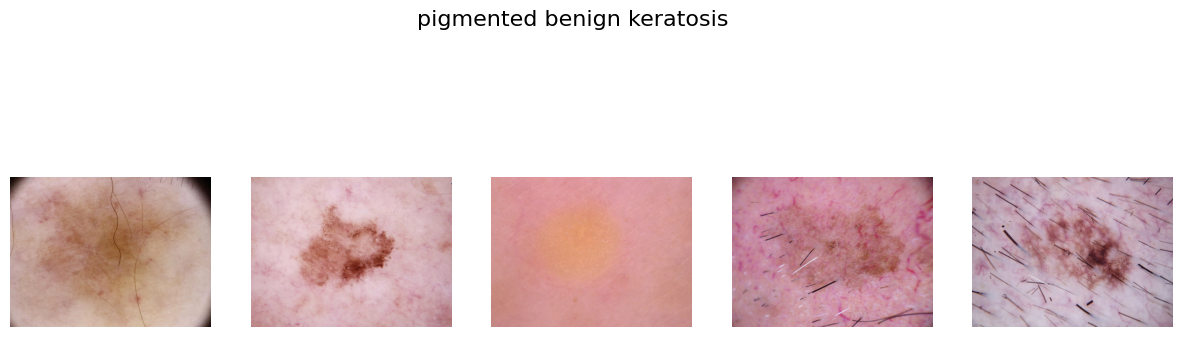

Subfolder: melanoma


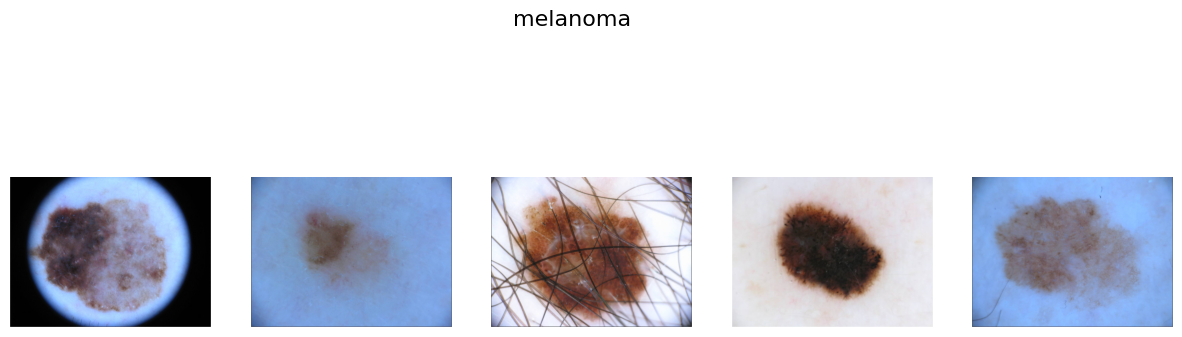

Subfolder: vascular lesion


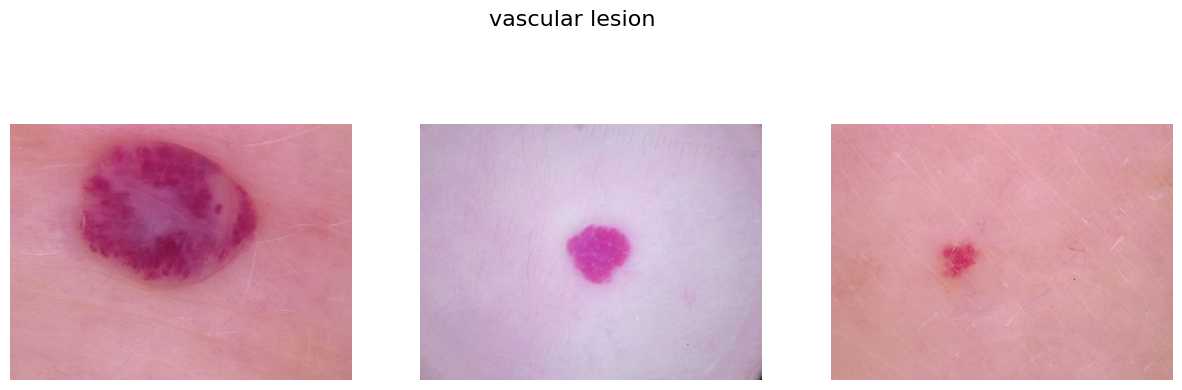

Subfolder: actinic keratosis


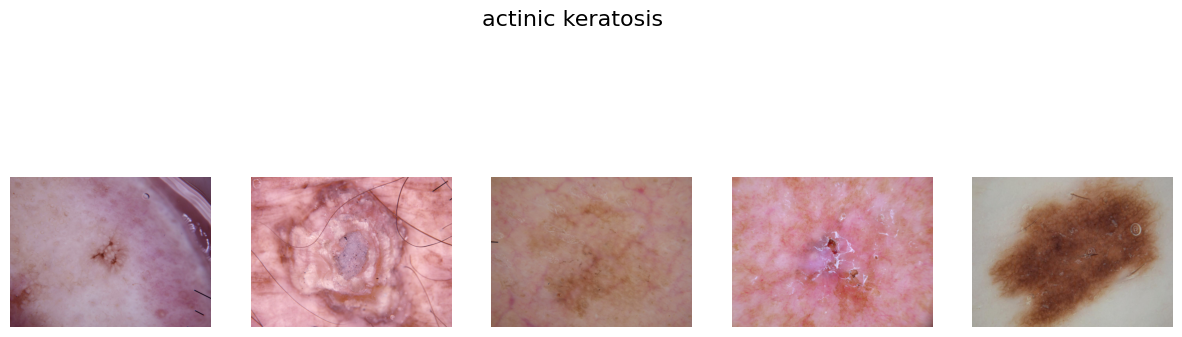

Subfolder: squamous cell carcinoma


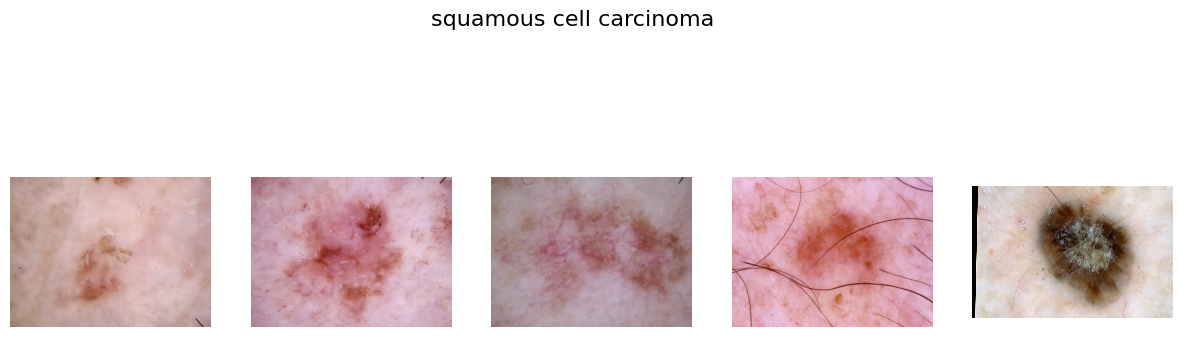

Subfolder: basal cell carcinoma


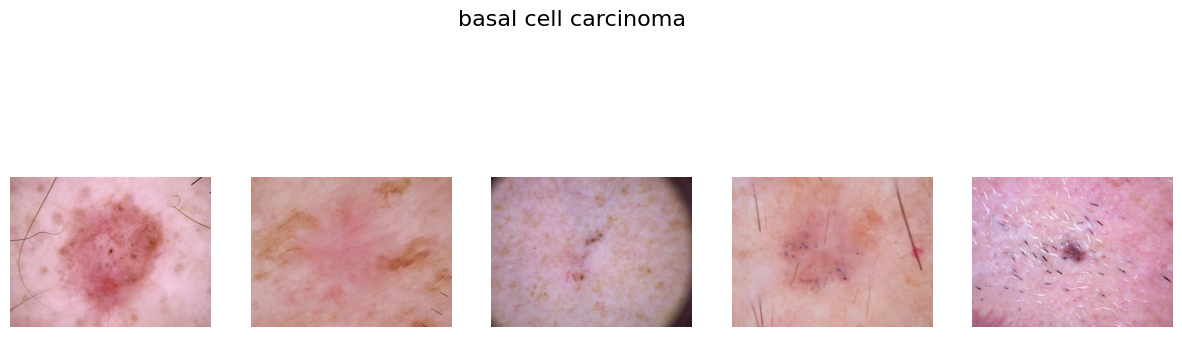

Subfolder: seborrheic keratosis


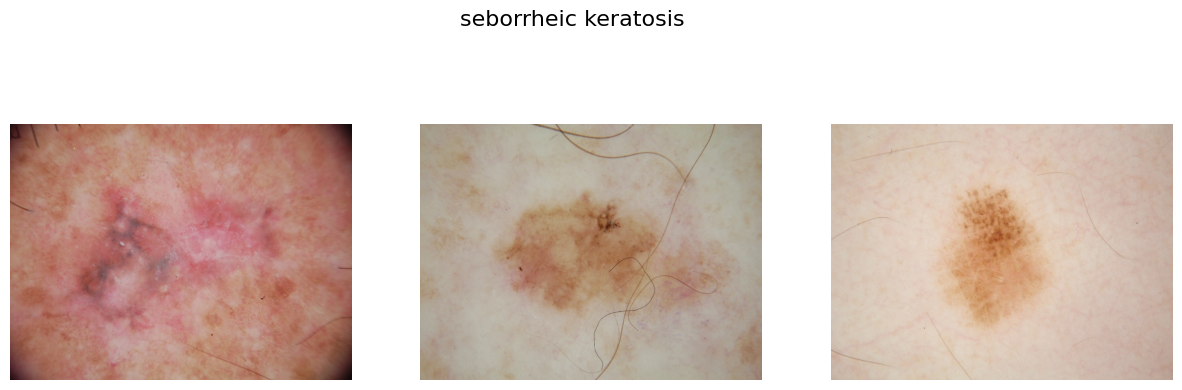

Subfolder: dermatofibroma


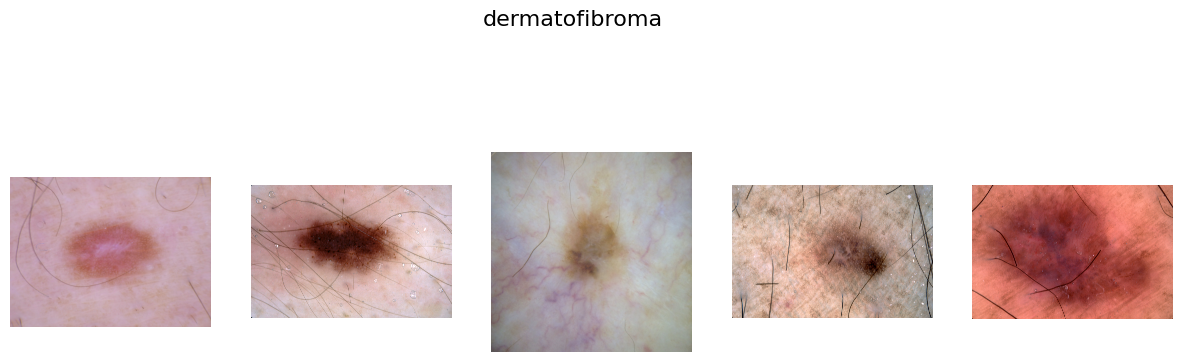

Subfolder: nevus


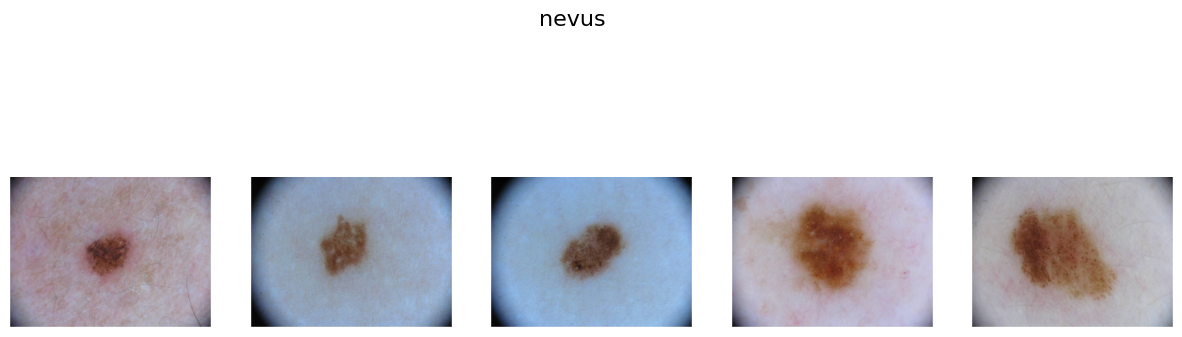

In [322]:
print('Testing Data--First 5 images')
display_images(test_contents)

Training Data--First 5 images
Subfolder: pigmented benign keratosis


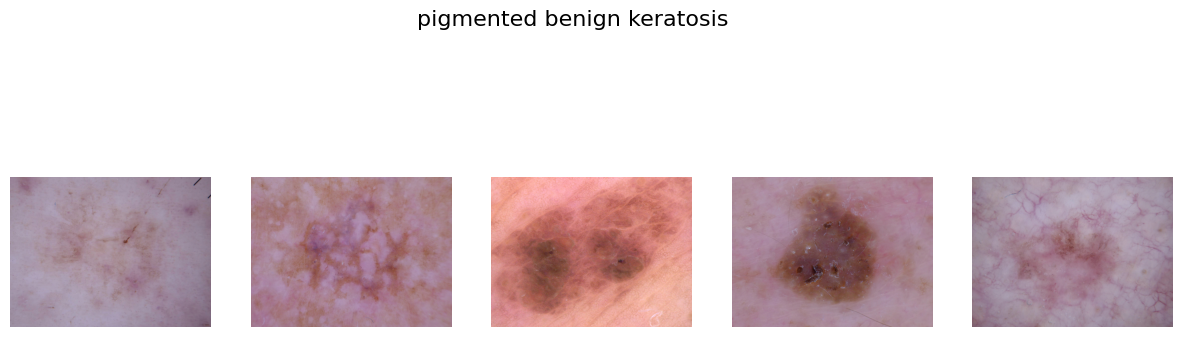

Subfolder: melanoma


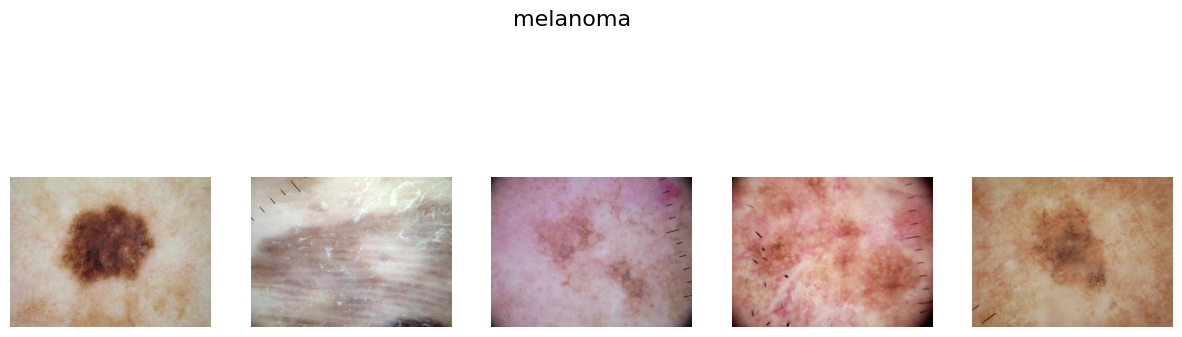

Subfolder: vascular lesion


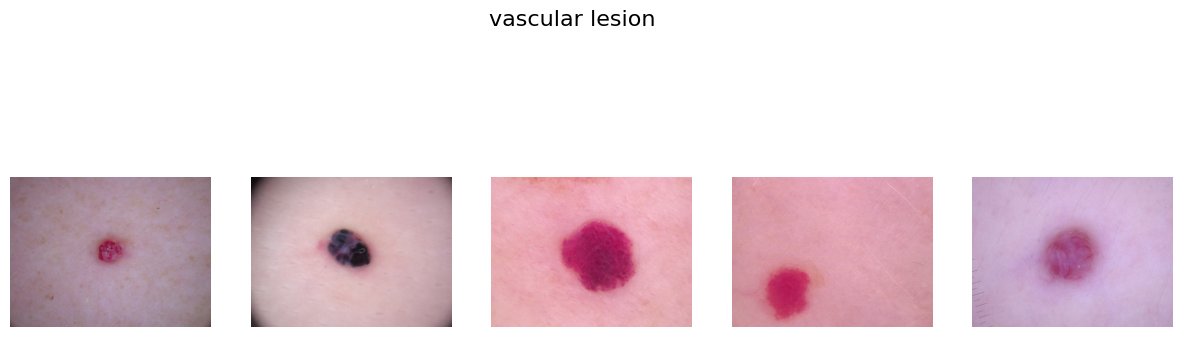

Subfolder: actinic keratosis


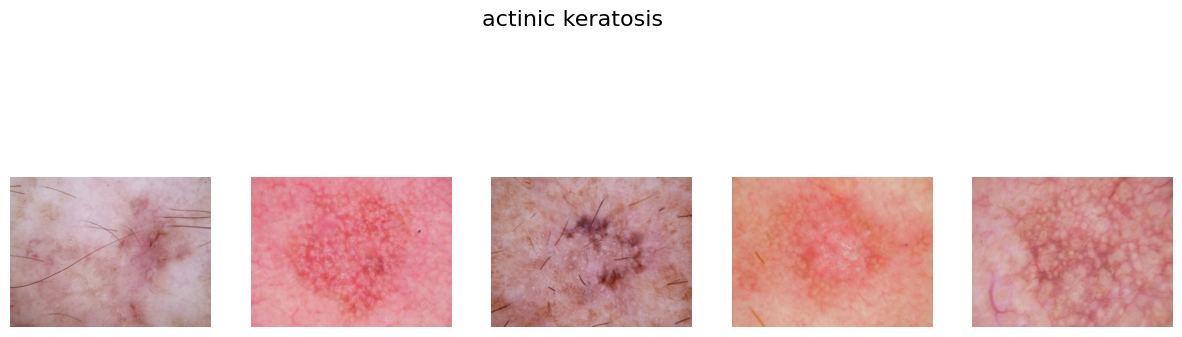

Subfolder: squamous cell carcinoma


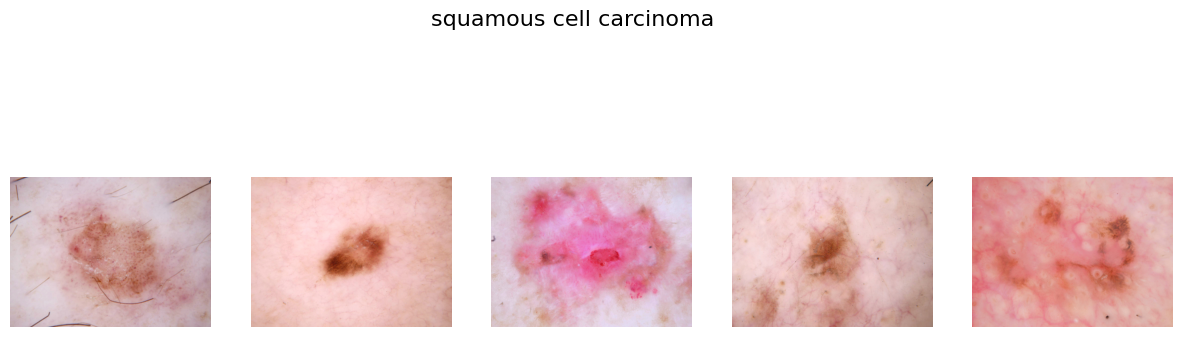

Subfolder: basal cell carcinoma


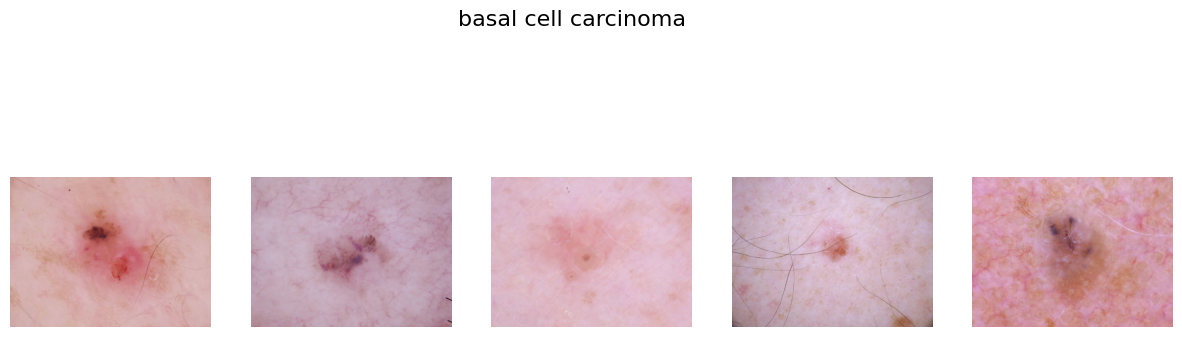

Subfolder: seborrheic keratosis


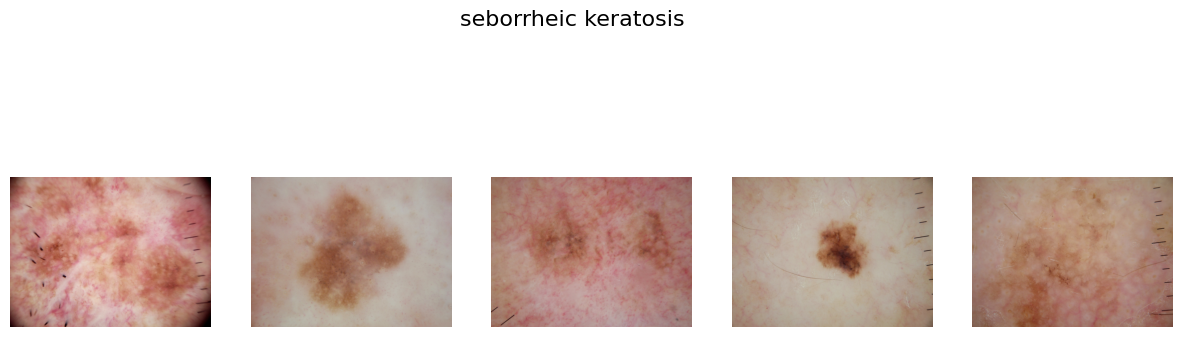

Subfolder: dermatofibroma


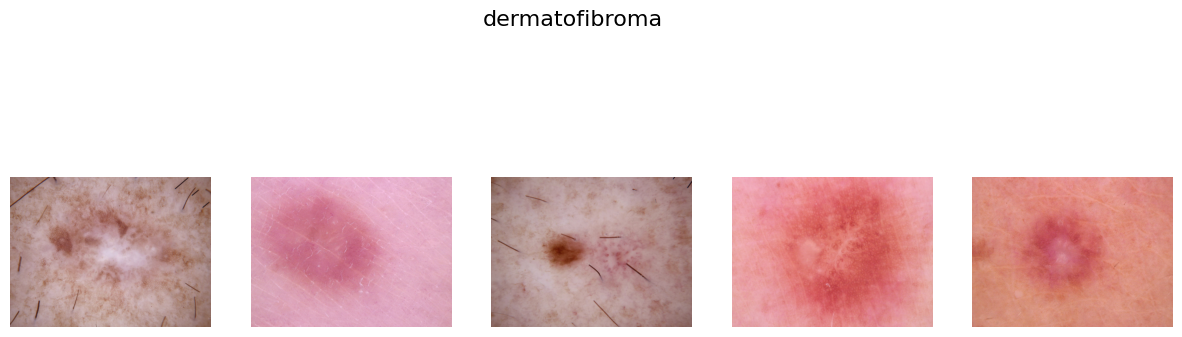

Subfolder: nevus


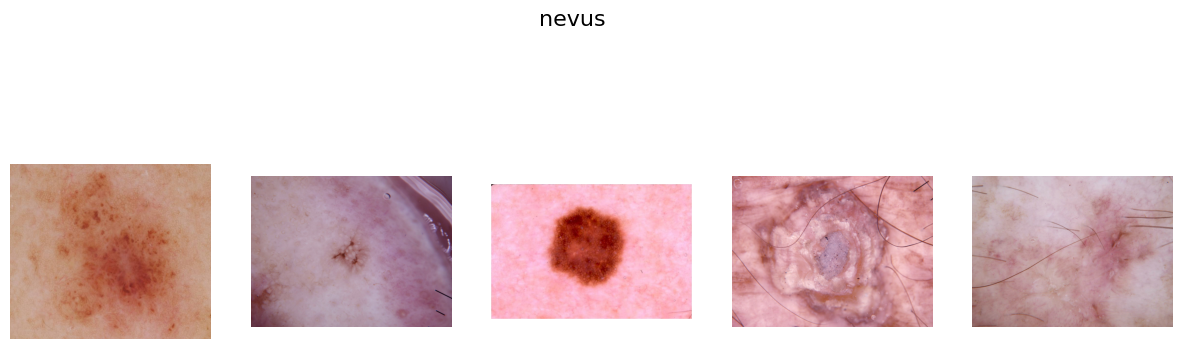

In [323]:
print('Training Data--First 5 images')
display_images(train_contents)

In [324]:
def plot_histogram(data, title):
    plt.figure(figsize=(10, 6))
    plt.bar(range(len(data)), list(data.values()), align='center', color='skyblue')
    plt.xticks(range(len(data)), list(data.keys()), rotation=45)
    plt.xlabel('Type')
    plt.ylabel('Count')
    plt.title(title)
    plt.tight_layout()
    plt.show()

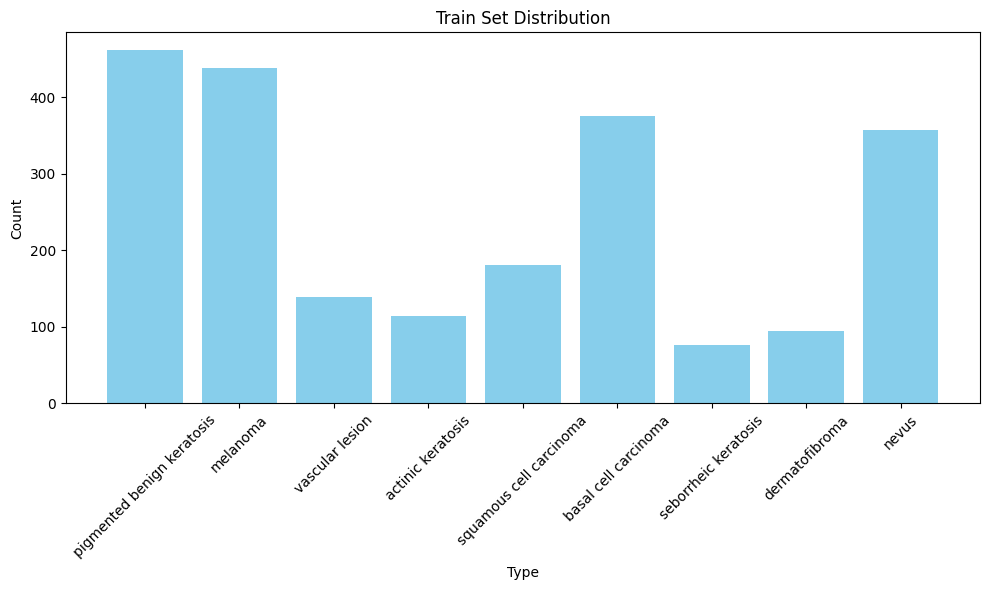

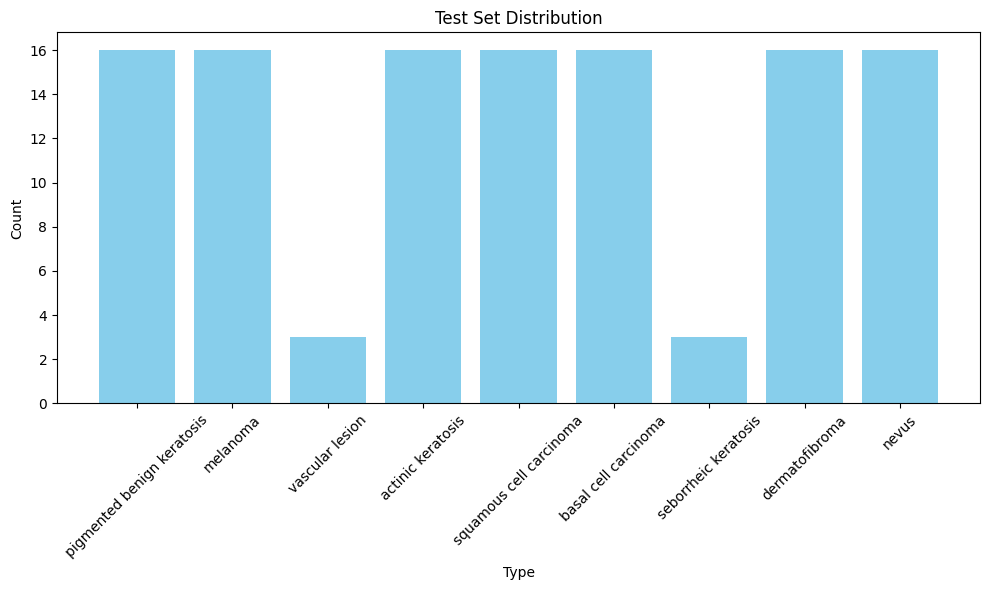

In [325]:
train_histogram = {key: len(value) for key, value in train_contents.items()}
test_histogram = {key: len(value) for key, value in test_contents.items()}

plot_histogram(train_histogram, 'Train Set Distribution')
plot_histogram(test_histogram, 'Test Set Distribution')

### There is uneven distribution for some classes. Need to correct.

In [401]:
def sample_data(data, sample_size):
    sampled_data = {}
    for key, value in data.items():
        sampled_data[key] = random.sample(value, sample_size) if len(value) > sample_size else value
    return sampled_data

In [402]:
min_count_train = min(len(images) for images in train_contents.values())
min_count_test = min(len(images) for images in test_contents.values())

sampled_train_contents = sample_data(train_contents, min_count_train)
sampled_test_contents = sample_data(test_contents, min_count_test)

In [328]:
# sampled_train_contents

In [403]:
class_names = list(sampled_train_contents.keys())
class_names = {v: k for k, v in enumerate(class_names)}

class_names

{'pigmented benign keratosis': 0,
 'melanoma': 1,
 'vascular lesion': 2,
 'actinic keratosis': 3,
 'squamous cell carcinoma': 4,
 'basal cell carcinoma': 5,
 'seborrheic keratosis': 6,
 'dermatofibroma': 7,
 'nevus': 8}

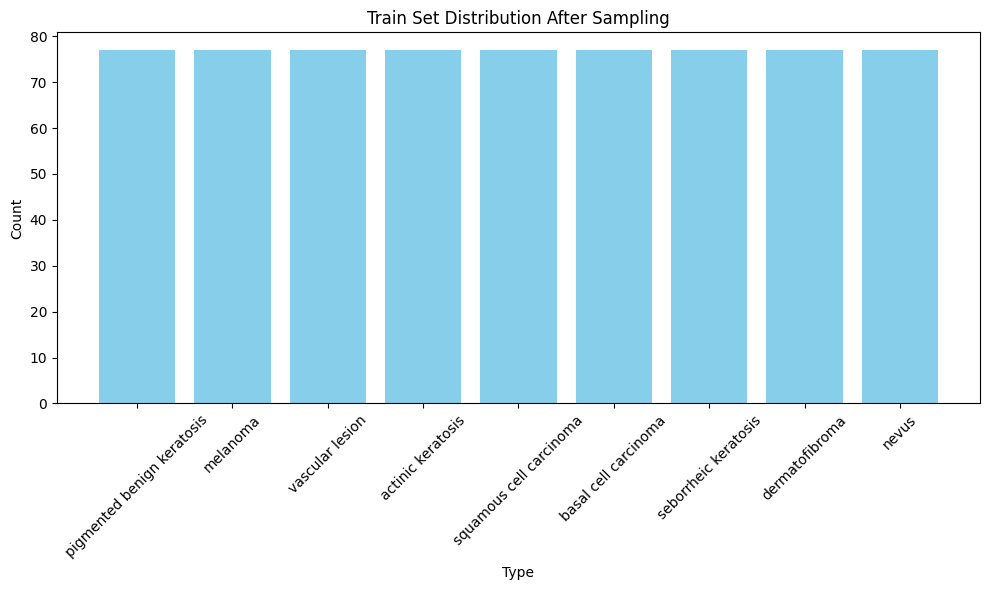

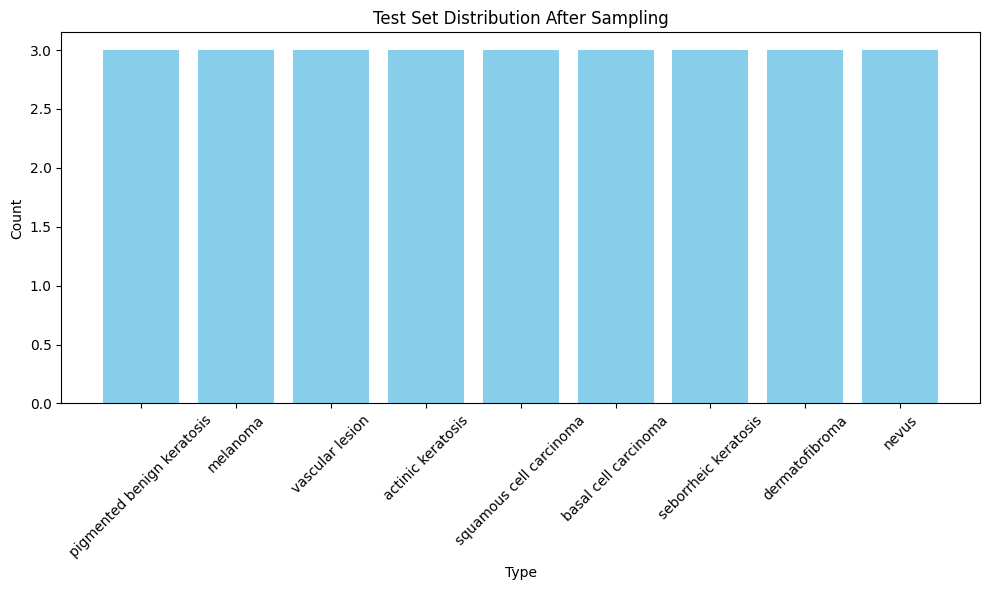

In [404]:
train_histogram = {key: len(value) for key, value in sampled_train_contents.items()}
test_histogram = {key: len(value) for key, value in sampled_test_contents.items()}

plot_histogram(train_histogram, 'Train Set Distribution After Sampling')
plot_histogram(test_histogram, 'Test Set Distribution After Sampling')

In [405]:
for key, value in sampled_train_contents.items():
    print(f"Key: {key}, Number of Values: {len(value)}")

Key: pigmented benign keratosis, Number of Values: 77
Key: melanoma, Number of Values: 77
Key: vascular lesion, Number of Values: 77
Key: actinic keratosis, Number of Values: 77
Key: squamous cell carcinoma, Number of Values: 77
Key: basal cell carcinoma, Number of Values: 77
Key: seborrheic keratosis, Number of Values: 77
Key: dermatofibroma, Number of Values: 77
Key: nevus, Number of Values: 77


In [432]:
test_image_paths = get_image_paths(sampled_test_contents)
train_image_paths = get_image_paths(sampled_train_contents)
print('done')

done


# Data preprocessing

In [407]:
def resize_image(image_path, target_size=(224, 224)):
    with Image.open(image_path) as img:
        img = img.resize(target_size)
        return img
    
def normalize_image(image):
    image_array = np.array(image) / 255.0
    return image_array

In [333]:
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

def augment_image(image_array):
    image_array = image_array.reshape((1,) + image_array.shape)  # Reshape for ImageDataGenerator
    aug_iter = datagen.flow(image_array)
    return next(aug_iter)[0]

In [334]:
def preprocess_image(image_paths, target_size=(224, 224)):
    
    image_tensors = []
    
    for image_path in image_paths:
        img = Image.open(image_path)
        img = img.resize(target_size)
        img_array = np.array(img) / 255.0
        img_array = augment_image(img_array)

        img_tensor = tf.convert_to_tensor(img_array, dtype=tf.float32)
        img_tensor = tf.expand_dims(img_tensor, axis=0)
        
        image_tensors.append(img_tensor)

    return image_tensors

In [335]:
processed_image_train = preprocess_image(train_image_paths)
processed_image_test = preprocess_image(test_image_paths)

In [337]:
def assign_class_labels(sampled_contents, class_names):
    y = []
    for class_name, image_paths in sampled_contents.items():
        class_index = class_names.index(class_name)
        y.extend([class_index] * len(image_paths))
    return y

In [408]:
X_train = processed_image_train
X_test = processed_image_test

class_names = list(sampled_train_contents.keys())
y_train = assign_class_labels(sampled_train_contents, class_names)
y_test = assign_class_labels(sampled_test_contents, class_names)
print(y_train)
print(y_test)

y_train = to_categorical(y_train, num_classes=9)
y_test = to_categorical(y_test, num_classes=9)

print(y_train)
print(y_test)

print('done')

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 

In [424]:
X_train_concatenated = tf.concat(X_train, axis=0)
X_train = np.array(X_train_concatenated)
#X_train = np.squeeze(X_train, axis=1)
y_train = np.array(y_train)

X_test_concatenated = tf.concat(X_test, axis=0)
X_test = np.array(X_test_concatenated)
#X_train = np.squeeze(X_train, axis=1)
y_test = np.array(y_test)

X_test = np.array(X_test)
y_test = np.array(y_test)

In [425]:
print(len(y_test))
print(len(X_test))

print(len(y_train))
print(len(X_train))

27
27
693
693


# Model training and fitting

In [418]:
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))  # Add dropout layer for regularization
model.add(Dense(9, activation='softmax'))

# Compile the model with Adam optimizer
adam = tf.keras.optimizers.Adam(learning_rate=0.001)  # Use Adam optimizer with a smaller learning rate
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])


# Compile the model
adam = Adam(learning_rate=0.001)
model.compile(optimizer=adam,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Display model summary
model.summary()

Model: "sequential_29"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_102 (Conv2D)             │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_107               │ (None, 111, 111, 32)   │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_103 (Conv2D)             │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_108               │ (None, 54, 54, 64)     │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_104 (Conv2D)             │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_109               │ (None, 26, 26, 128)    │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_105 (Conv2D)             │ (None, 24, 24, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_110               │ (None, 12, 12, 128)    │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_41 (Flatten)            │ (None, 18432)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_90 (Dense)                │ (None, 512)            │     9,437,696 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_46 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_91 (Dense)                │ (None, 9)              │         4,617 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,683,145 (36.94 MB)

 Trainable params: 9,683,145 (36.94 MB)

 Non-trainable params: 0 (0.00 B)

In [426]:
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_train type:", X_train.dtype)
print("y_train type:", y_train.dtype)

X_train shape: (693, 224, 224, 3)
y_train shape: (693, 9)
X_train type: float32
y_train type: float64


In [427]:
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2, verbose=1, shuffle=True)

Epoch 1/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 35s 2s/step - accuracy: 0.1371 - loss: 2.2846 - val_accuracy: 0.0000e+00 - val_loss: 3.7570
Epoch 2/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 40s 2s/step - accuracy: 0.1139 - loss: 2.0652 - val_accuracy: 0.0000e+00 - val_loss: 4.5034
Epoch 3/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - accuracy: 0.1969 - loss: 1.9728 - val_accuracy: 0.0000e+00 - val_loss: 4.6686
Epoch 4/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - accuracy: 0.3114 - loss: 1.7645 - val_accuracy: 0.0000e+00 - val_loss: 5.0342
Epoch 5/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 33s 2s/step - accuracy: 0.2441 - loss: 1.8735 - val_accuracy: 0.0000e+00 - val_loss: 4.8087
Epoch 6/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 32s 2s/step - accuracy: 0.3113 - loss: 1.6933 - val_accuracy: 0.0000e+00 - val_loss: 5.9074
Epoch 7/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - accuracy: 0.3477 - loss: 1.5921 - val_accuracy: 0.0000e+00 - val_loss: 8.6060
Epoch 8/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 33s 2s/step - accuracy: 0.4791 - loss: 1.3295 - val_

In [385]:
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=1)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step - accuracy: 0.3704 - loss: 3.3215
Test Loss: 3.3214895725250244
Test Accuracy: 0.37037035822868347


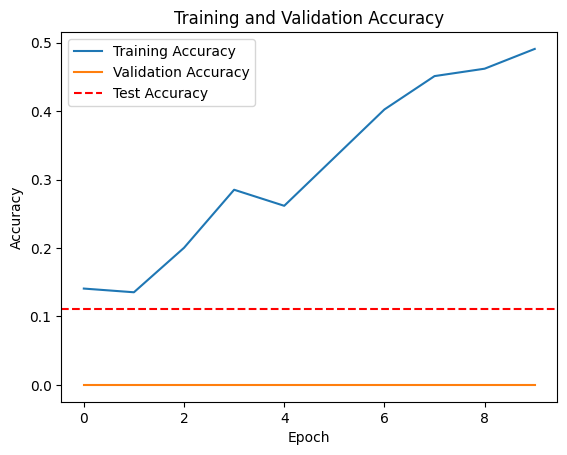

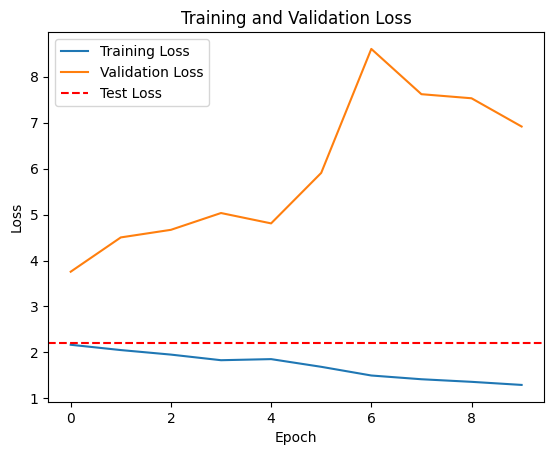

In [430]:
# Plot training and validation accuracy per epoch
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.axhline(y=test_accuracy, color='r', linestyle='--', label='Test Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training and validation loss per epoch
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.axhline(y=test_loss, color='r', linestyle='--', label='Test Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [387]:
# history = model.fit(X_train, y_train, epochs=10, batch_size=32, verbose=1, shuffle=True)

# # After each epoch, evaluate the model on the testing data
# for epoch in range(10):
#     model.fit(X_train, y_train, epochs=1, batch_size=32, verbose=1, shuffle=True)
#     loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
#     print("Epoch {}, Testing Loss: {}, Testing Accuracy: {}".format(epoch+1, loss, accuracy))

Epoch 1/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 17s 760ms/step - accuracy: 0.3226 - loss: 2.3338
Epoch 2/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 20s 763ms/step - accuracy: 0.3285 - loss: 1.8560
Epoch 3/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 16s 745ms/step - accuracy: 0.3285 - loss: 1.7006
Epoch 4/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 17s 768ms/step - accuracy: 0.3718 - loss: 1.6618
Epoch 5/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 16s 744ms/step - accuracy: 0.3485 - loss: 1.6612
Epoch 6/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 17s 768ms/step - accuracy: 0.3391 - loss: 1.6439
Epoch 7/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 16s 738ms/step - accuracy: 0.3942 - loss: 1.5998
Epoch 8/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 17s 759ms/step - accuracy: 0.4129 - loss: 1.5003
Epoch 9/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 16s 748ms/step - accuracy: 0.4274 - loss: 1.4521
Epoch 10/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 17s 758ms/step - accuracy: 0.4515 - loss: 1.3592
22/22 ━━━━━━━━━━━━━━━━━━━━ 16s 737ms/step - accuracy: 0.5011 - loss: 1.3946
Epoch 1, Testing Loss: 2.24544095993042, Testing Accu

22/22 ━━━━━━━━━━━━━━━━━━━━ 17s 762ms/step - accuracy: 0.6114 - loss: 1.0187
Epoch 1, Testing Loss: 2.3145134449005127
22/22 ━━━━━━━━━━━━━━━━━━━━ 16s 741ms/step - accuracy: 0.6672 - loss: 0.9090
Epoch 2, Testing Loss: 2.7418081760406494
22/22 ━━━━━━━━━━━━━━━━━━━━ 17s 762ms/step - accuracy: 0.6737 - loss: 0.9299
Epoch 3, Testing Loss: 2.916687488555908
22/22 ━━━━━━━━━━━━━━━━━━━━ 16s 740ms/step - accuracy: 0.7004 - loss: 0.8089
Epoch 4, Testing Loss: 3.1150989532470703
22/22 ━━━━━━━━━━━━━━━━━━━━ 17s 756ms/step - accuracy: 0.6979 - loss: 0.8458
Epoch 5, Testing Loss: 3.223235845565796
22/22 ━━━━━━━━━━━━━━━━━━━━ 16s 740ms/step - accuracy: 0.6854 - loss: 0.9115
Epoch 6, Testing Loss: 2.826903820037842
22/22 ━━━━━━━━━━━━━━━━━━━━ 17s 746ms/step - accuracy: 0.7434 - loss: 0.7953
Epoch 7, Testing Loss: 3.613409996032715
22/22 ━━━━━━━━━━━━━━━━━━━━ 17s 767ms/step - accuracy: 0.7419 - loss: 0.8048
Epoch 8, Testing Loss: 2.9311306476593018
22/22 ━━━━━━━━━━━━━━━━━━━━ 19s 864ms/step - accuracy: 0.7647

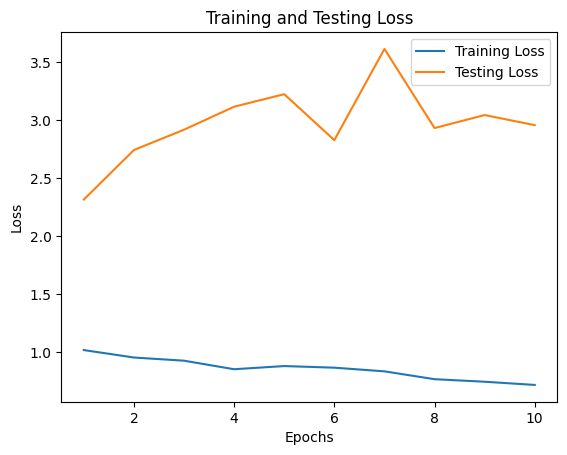

In [389]:
# import matplotlib.pyplot as plt

# # Lists to store training and testing loss
# train_loss = []
# test_loss = []

# # Training loop
# for epoch in range(10):
#     history = model.fit(X_train, y_train, epochs=1, batch_size=32, verbose=1, shuffle=True)
    
#     # Append training loss
#     train_loss.append(history.history['loss'][0])
    
#     # Evaluate the model on the testing data
#     loss, _ = model.evaluate(X_test, y_test, verbose=0)
    
#     # Append testing loss
#     test_loss.append(loss)
    
#     print("Epoch {}, Testing Loss: {}".format(epoch+1, loss))

# # Plotting
# plt.plot(range(1, 11), train_loss, label='Training Loss')
# plt.plot(range(1, 11), test_loss, label='Testing Loss')
# plt.xlabel('Epochs')
# plt.ylabel('Loss')
# plt.title('Training and Testing Loss')
# plt.legend()
# plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step


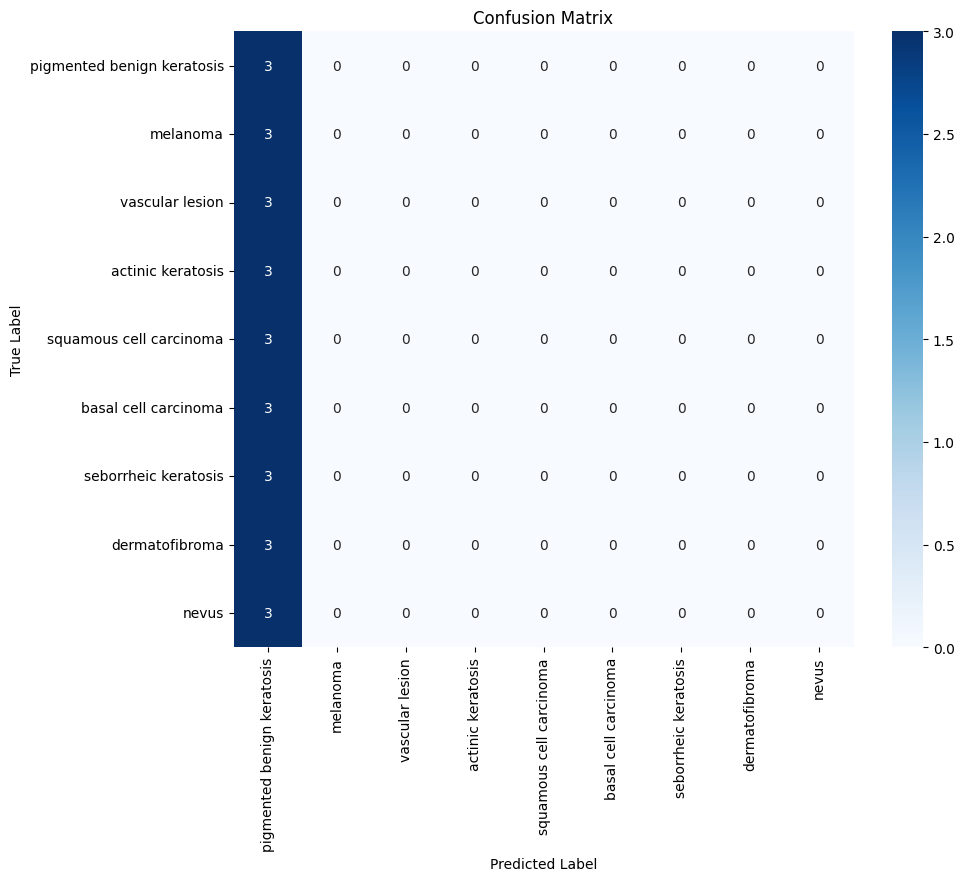

In [431]:
# Predictions on the test set
y_pred = model_transfer.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Confusion matrix
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)

# Plotting the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

### Model is not performing very well. Can use transfer learning to get better accuracy.

# Transfer Learning

In [390]:
img_width, img_height = 224, 224
input_shape = (img_width, img_height, 3)
num_classes = 9

base_model = EfficientNetB7(weights='imagenet', include_top=False, input_shape=input_shape)

# Freeze the layers of the pre-trained model
for layer in base_model.layers:
    layer.trainable = False

x = base_model.output
x = Flatten()(x)
x = Dense(128, activation='relu')(x)  
x = Dense(64, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(num_classes, activation='softmax')(x)

model_transfer = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
adam = Adam(learning_rate=0.001)
model_transfer.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])

In [397]:
model_transfer.summary()

Model: "functional_225"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_32      │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_8         │ (None, 224, 224,  │          0 │ input_layer_32[0… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization_4     │ (None, 224, 224,  │          7 │ rescaling_8[0][0] │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_9         │ (None, 224, 224,  │          0 │ normalization_4[… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 225, 225,  │          0 │ rescaling_9[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │      1,728 │ stem_conv_pad[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        256 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 112, 112,  │        576 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 112, 112,  │        256 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 112, 112,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 64)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 64)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 16)  │      1,040 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 64)  │      1,088 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 112, 112,  │          0 │ block1a_activati… │
│ (Multiply)          │ 64)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 112, 112,  │      2,048 │ block1a_se_excit

 Total params: 112,293,556 (428.37 MB)

 Trainable params: 16,065,289 (61.28 MB)

 Non-trainable params: 64,097,687 (244.51 MB)

 Optimizer params: 32,130,580 (122.57 MB)

In [395]:
history_2 = model_transfer.fit(X_train, y_train, epochs=5, batch_size=32, validation_split=0.2, verbose=1, shuffle=True)

Epoch 1/5
18/18 ━━━━━━━━━━━━━━━━━━━━ 174s 10s/step - accuracy: 0.1547 - loss: 2.1693 - val_accuracy: 0.0000e+00 - val_loss: 2.3363
Epoch 2/5
18/18 ━━━━━━━━━━━━━━━━━━━━ 213s 10s/step - accuracy: 0.1560 - loss: 2.1646 - val_accuracy: 0.0000e+00 - val_loss: 2.3675
Epoch 3/5
18/18 ━━━━━━━━━━━━━━━━━━━━ 177s 10s/step - accuracy: 0.1494 - loss: 2.1575 - val_accuracy: 0.0000e+00 - val_loss: 2.4010
Epoch 4/5
18/18 ━━━━━━━━━━━━━━━━━━━━ 177s 10s/step - accuracy: 0.1413 - loss: 2.1502 - val_accuracy: 0.0000e+00 - val_loss: 2.4342
Epoch 5/5
18/18 ━━━━━━━━━━━━━━━━━━━━ 175s 10s/step - accuracy: 0.1403 - loss: 2.1466 - val_accuracy: 0.0000e+00 - val_loss: 2.4676


In [392]:
test_loss, test_accuracy = model_transfer.evaluate(X_test, y_test, verbose=1)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step - accuracy: 0.1111 - loss: 2.1989
Test Loss: 2.1989030838012695
Test Accuracy: 0.1111111119389534


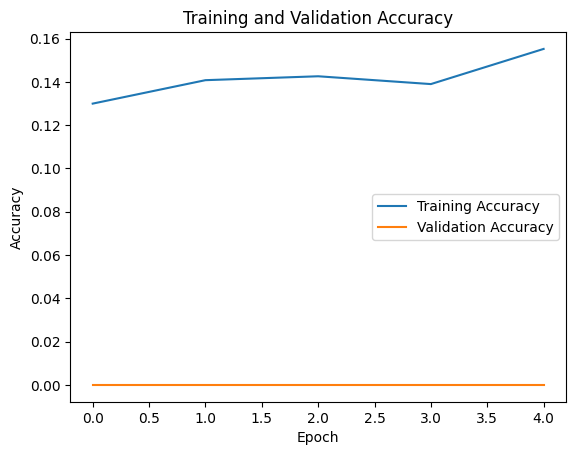

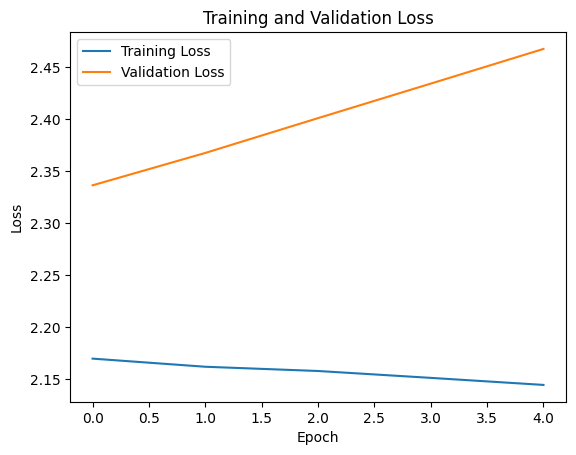

In [396]:
# Plot training and validation accuracy per epoch
plt.plot(history_2.history['accuracy'], label='Training Accuracy')
plt.plot(history_2.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training and validation loss per epoch
plt.plot(history_2.history['loss'], label='Training Loss')
plt.plot(history_2.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step


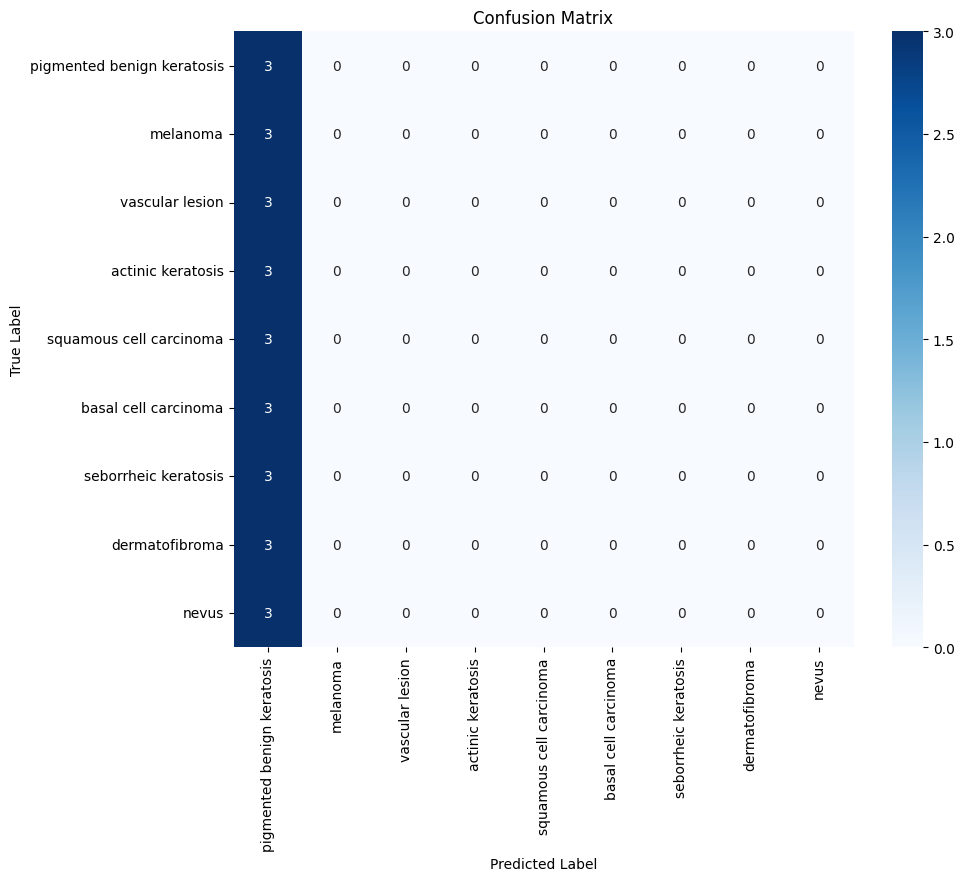

In [429]:
# Predictions on the test set
y_pred = model_transfer.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Confusion matrix
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)

# Plotting the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()